In [1]:
import scanpy as sc
import pandas as pd

In [2]:
adata_197_epi = sc.read_h5ad("/home/augusta/SSS_mount/insituCNV/data/WTx-CosMx_TVA/snPATHO-seq/adata_lab_lv2-B-1970164-01-04_2,epi.h5ad")

In [3]:
adata_197_epi

AnnData object with n_obs × n_vars = 15497 × 15502
    obs: 'library', 'barcode', 'sid', 'sum', 'detected', 'subsets_mt_sum', 'subsets_mt_detected', 'subsets_mt_percent', 'total', 'sizeFactor', 'kid_lv1', 'lab_lv1', 'kid_lv2', 'lab_lv2'
    var: 'gene_id', 'gene_symbol', 'hv'
    uns: 'X_name'
    obsm: 'PCA', 'UMAP'
    layers: 'logcounts'

In [6]:
adata_197_epi.X

<Compressed Sparse Column sparse matrix of dtype 'float64'
	with 31474340 stored elements and shape (15497, 15502)>

In [13]:
sc.pp.calculate_qc_metrics(adata_197_epi, inplace= True)

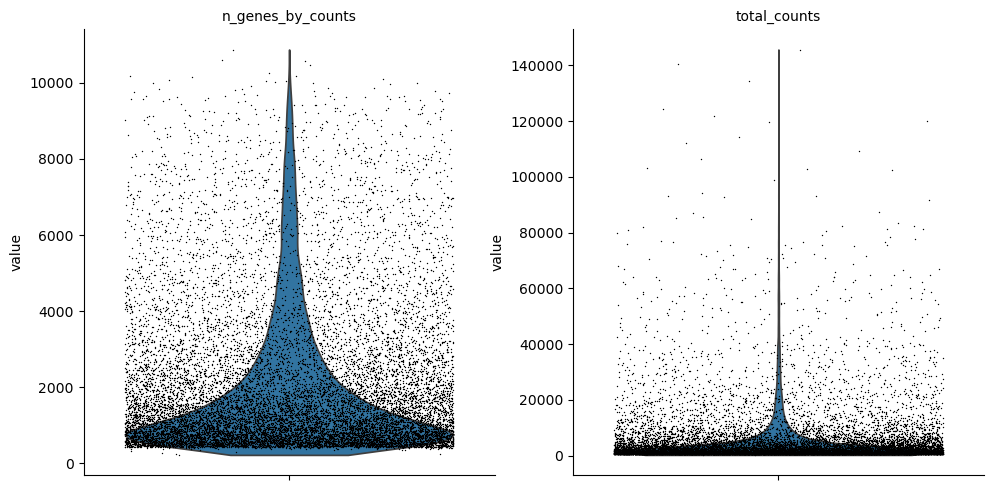

In [14]:
sc.pl.violin(
    adata_197_epi,
    ["n_genes_by_counts", "total_counts"],
    jitter=0.4,
    multi_panel=True,
)

In [16]:
# Saving count data
adata_197_epi.layers["counts"] = adata_197_epi.X.copy()

In [17]:
# Normalizing to median total counts
sc.pp.normalize_total(adata_197_epi)
# Logarithmize the data
sc.pp.log1p(adata_197_epi)

In [20]:
sc.pp.highly_variable_genes(adata_197_epi, n_top_genes=2000)

In [21]:
sc.tl.pca(adata_197_epi)

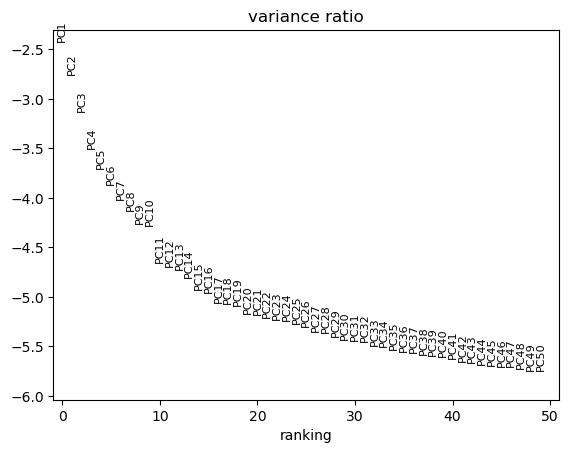

In [23]:
sc.pl.pca_variance_ratio(adata_197_epi, n_pcs=50, log=True)

In [24]:
adata_197_epi

AnnData object with n_obs × n_vars = 15497 × 15502
    obs: 'library', 'barcode', 'sid', 'sum', 'detected', 'subsets_mt_sum', 'subsets_mt_detected', 'subsets_mt_percent', 'total', 'sizeFactor', 'kid_lv1', 'lab_lv1', 'kid_lv2', 'lab_lv2', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes'
    var: 'gene_id', 'gene_symbol', 'hv', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'X_name', 'log1p', 'hvg', 'pca'
    obsm: 'PCA', 'UMAP', 'X_pca'
    varm: 'PCs'
    layers: 'logcounts', 'counts'

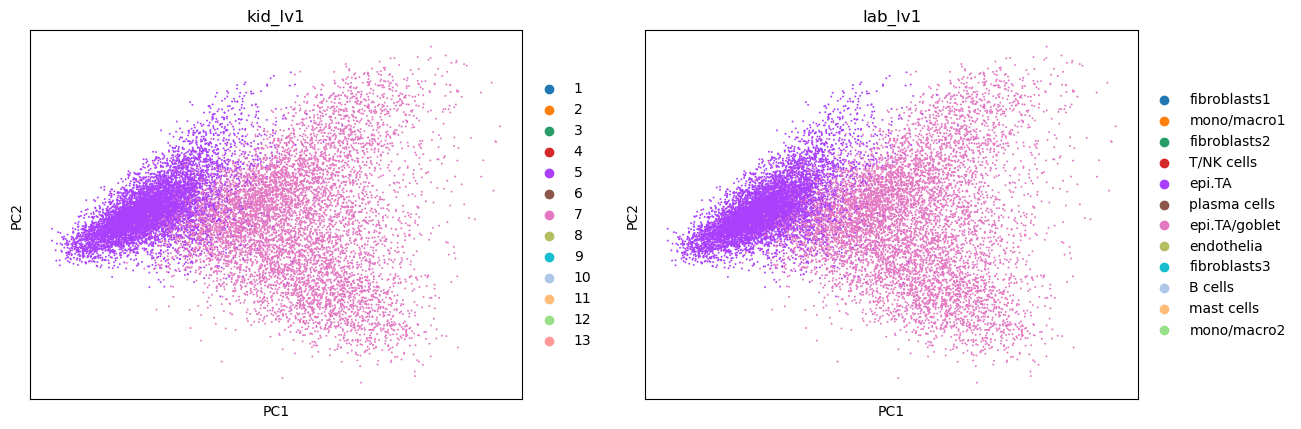

In [34]:
sc.pl.pca(adata_197_epi, color=['kid_lv1', 'lab_lv1'])

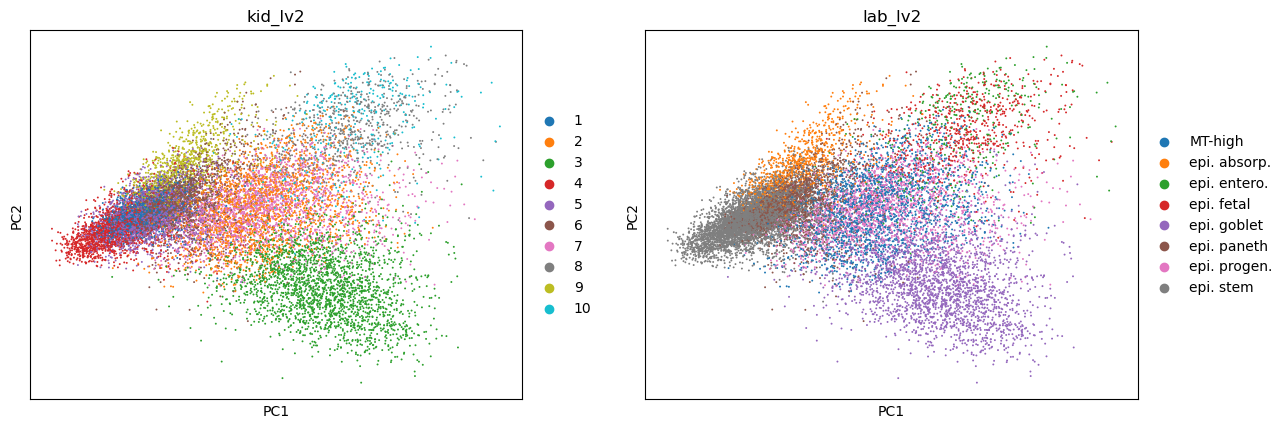

In [33]:
sc.pl.pca(adata_197_epi, color=['kid_lv2', 'lab_lv2'])

In [36]:
sc.pp.neighbors(adata_197_epi)

In [37]:
sc.tl.umap(adata_197_epi)

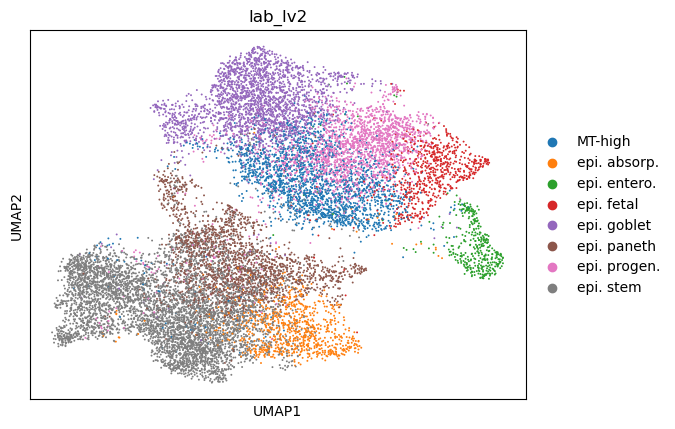

In [42]:
sc.pl.umap(
    adata_197_epi,
    color="lab_lv2"
    # Setting a smaller point size to get prevent overlap
    # size=4,
)

In [46]:
adata_197_epi.X

<Compressed Sparse Column sparse matrix of dtype 'float64'
	with 31474340 stored elements and shape (15497, 15502)>

## Run inferCNV

In [48]:
import infercnvpy as cnv

In [51]:
def add_genomic_positions(adata):
    ''' Adds gene positions to the AnnData object. The adata.var_names have to be EnsmblIDs. The data is taken from the Ensmbl BioMart human dataset GRCh38.p14. 

    param:
        adata (AnnData object): the annotated dataset where the gene postions should be added
    output: 
        adata (AnnData object): the annotated dataset where the genes are added
 
    '''

    
    # Load the gene positions data
    gene_file = ("/home/augusta/SSS_mount/insituCNV/InSituCNV/Ensmbl_BioMart_gene_info.txt")
    gene_positions_df = pd.read_csv(gene_file)

    # Create a dictionary for quick lookup
    gene_dict = gene_positions_df.set_index("Gene stable ID")[["Chromosome/scaffold name", "Gene start (bp)", "Gene end (bp)"]].to_dict("index")

    # Format chromosome names
    format_chromosome = lambda x: f"chr{x}"

    # Initialize counters
    genes_identified = 0

    # Iterate over the genes in adata
    for gene_id in adata.var_names:
        if gene_id in gene_dict:
            info = gene_dict[gene_id]
            adata.var.loc[gene_id, ["chromosome", "start", "end"]] = [format_chromosome(info["Chromosome/scaffold name"]), info["Gene start (bp)"], info["Gene end (bp)"]]
            genes_identified += 1

    # Print summary of identified genes
    print(f"{genes_identified} gene positions identified \n{adata.shape[1] - genes_identified} were not found")
    return adata

In [58]:
adata_197_epi.var

,gene_id,gene_symbol,hv,n_cells_by_counts,mean_counts,log1p_mean_counts,pct_dropout_by_counts,total_counts,log1p_total_counts,highly_variable,means,dispersions,dispersions_norm
gene_symbol,,,,,,,,,,,,,
SAMD11,ENSG00000187634,SAMD11,False,72,0.005485,0.005470,99.535394,85.0,4.454347,False,0.002307,0.313962,-0.060743
NOC2L,ENSG00000188976,NOC2L,False,3481,0.417371,0.348804,77.537588,6468.0,8.774777,False,0.136649,0.343397,0.027780
KLHL17,ENSG00000187961,KLHL17,False,863,0.066464,0.064349,94.431180,1030.0,6.938284,False,0.026155,0.280203,-0.162273
PLEKHN1,ENSG00000187583,PLEKHN1,False,655,0.052655,0.051316,95.773375,816.0,6.705639,False,0.021493,0.440453,0.319669
PERM1,ENSG00000187642,PERM1,False,8,0.000516,0.000516,99.948377,8.0,2.197225,True,0.000293,0.706212,1.118919
...,...,...,...,...,...,...,...,...,...,...,...,...,...
MT-ND4L,ENSG00000212907,MT-ND4L,True,12258,14.225398,2.722965,20.900820,220451.0,12.303435,False,1.649240,1.325245,0.336365
MT-ND4,ENSG00000198886,MT-ND4,True,9828,4.581596,1.719475,36.581274,71001.0,11.170463,False,0.895618,0.683918,-0.301474
MT-ND5,ENSG00000198786,MT-ND5,False,6075,1.243015,0.807821,60.798864,19263.0,9.865993,False,0.335080,0.314824,-0.358472


In [59]:
adata_197_epi.var.index = adata_197_epi.var.gene_id

In [60]:
add_genomic_positions(adata_197_epi)

14928 gene positions identified 
574 were not found


AnnData object with n_obs × n_vars = 15497 × 15502
    obs: 'library', 'barcode', 'sid', 'sum', 'detected', 'subsets_mt_sum', 'subsets_mt_detected', 'subsets_mt_percent', 'total', 'sizeFactor', 'kid_lv1', 'lab_lv1', 'kid_lv2', 'lab_lv2', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes'
    var: 'gene_id', 'gene_symbol', 'hv', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'chromosome', 'start', 'end'
    uns: 'X_name', 'log1p', 'hvg', 'pca', 'lab_lv1_colors', 'lab_lv2_colors', 'kid_lv2_colors', 'kid_lv1_colors', 'neighbors', 'umap'
    obsm: 'PCA', 'UMAP', 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'logcounts', 'counts'
    obsp: 'distances', 'connectivities'

In [62]:
# We provide all immune cell types as "normal cells".
cnv.tl.infercnv(
    adata_197_epi,
    window_size=100
)

# We provide all immune cell types as "normal cells".


  0%|          | 0/4 [00:00<?, ?it/s]

/home/augusta/anaconda3/envs/scanpy_env/lib/python3.12/site-packages/scanpy/tools/_utils.py:41: UserWarning: You’re trying to run this on 1283 dimensions of `.X`, if you really want this, set `use_rep='X'`.
         Falling back to preprocessing with `sc.pp.pca` and default params.
  warnings.warn(


categories: MT-high, epi. absorp., epi. entero., etc.
var_group_labels: chr1, chr2, chr3, etc.


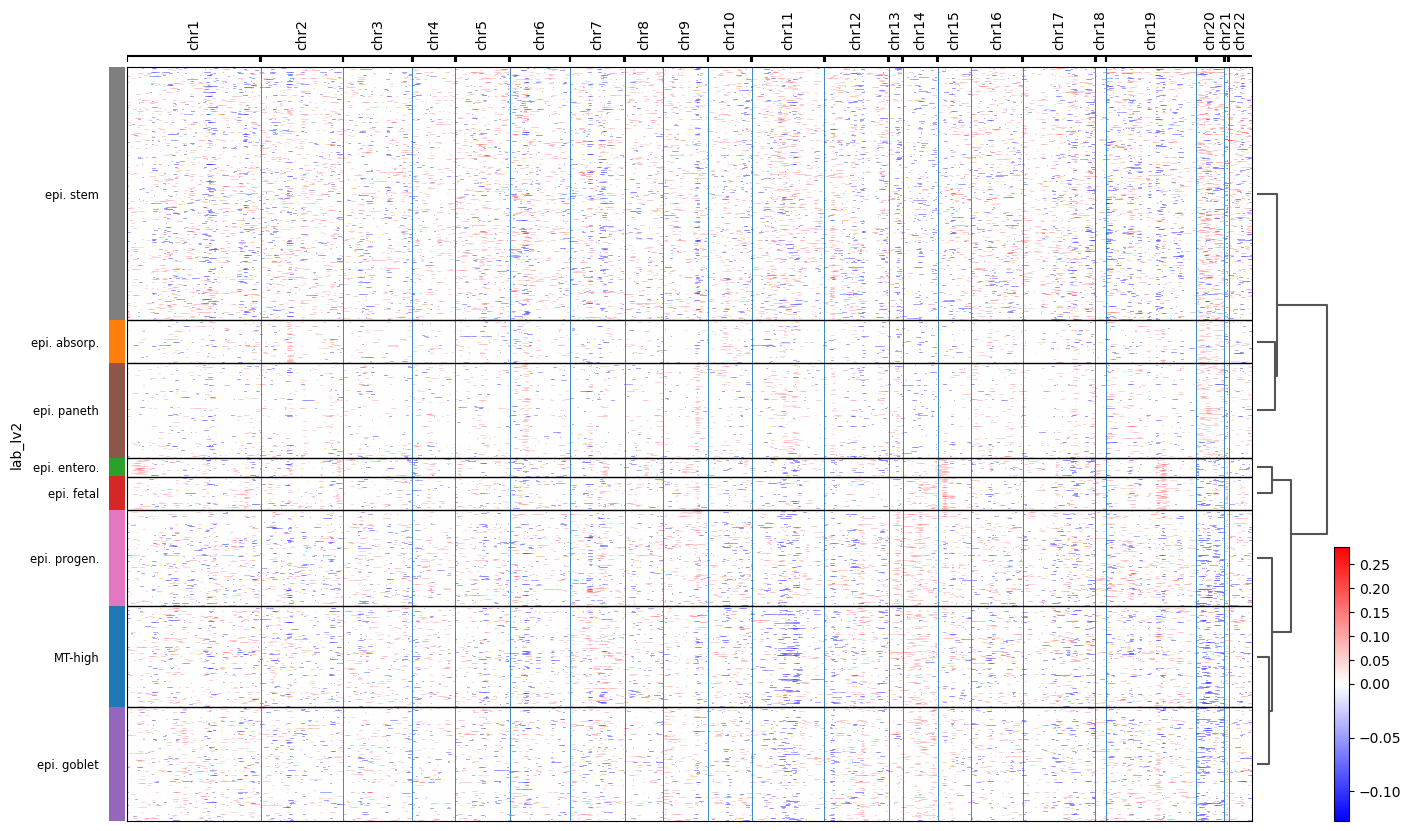

In [64]:
cnv.pl.chromosome_heatmap(adata_197_epi, groupby="lab_lv2", dendrogram=True)